# LangGraph 핸즈온

**참고하면 좋은 자료**

- [LangChain 한국어 튜토리얼🇰🇷](https://wikidocs.net/book/14314)
- [LangChain 한국어 튜토리얼 Github 소스코드](https://github.com/teddylee777/langchain-kr)
- [테디노트 YouTube](https://www.youtube.com/c/@teddynote)
- [테디노트 블로그](https://teddylee777.github.io/)
- [테디노트 YouTube 로 RAG 배우기!](https://teddylee777.notion.site/YouTube-RAG-10a24f35d12980dc8478c750faa752a2?pvs=74)
- [RAG 비법노트](https://fastcampus.co.kr/data_online_teddy)

## Part 0. 환경 설정

**OpenAI API Key 설정**
- https://wikidocs.net/233342

**웹 검색을 위한 API 키 발급 주소**
- https://app.tavily.com/

회원 가입 후 API Key를 발급합니다.

**설치를 진행합니다**

In [1]:
%pip install langgraph langchain_openai langchain_teddynote faiss-cpu pdfplumber langchain_community

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 13.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 9.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 8.9 MB/s eta 0:00:00a 0:00:0

**실습자료를 다운로드 받습니다**

In [3]:
import os
print(f"현재 작업 디렉토리: {os.getcwd()}")
print(1)

현재 작업 디렉토리: /Users/kb/repos/langcon-2025-handson
1


In [17]:
from dotenv import load_dotenv
import os

# .env 파일의 정확한 경로 지정
env_path = os.path.join(os.getcwd(), 'rag', '.env')
print(f"로드할 .env 파일 경로: {env_path}")

# .env 파일 존재 여부 확인
if os.path.exists(env_path):
    print(".env 파일이 존재합니다!")
    
    # .env 파일에서 환경 변수 로드
    load_dotenv(dotenv_path=env_path, override=True)
    
    # 환경 변수 확인
    openai_key = os.environ.get("OPENAI_API_KEY", "")
    tavily_key = os.environ.get("TAVILY_API_KEY", "")
    
    if openai_key:
        print(f"OpenAI API Key: {openai_key[:5]}...{openai_key[-4:] if len(openai_key) > 4 else ''}")
        print(f"OpenAI API Key 길이: {len(openai_key)}자")
    else:
        print("OpenAI API Key가 설정되지 않았습니다.")
    
    if tavily_key:
        print(f"Tavily API Key: {tavily_key[:7]}...{tavily_key[-4:] if len(tavily_key) > 4 else ''}")
        print(f"Tavily API Key 길이: {len(tavily_key)}자")
    else:
        print("Tavily API Key가 설정되지 않았습니다.")
else:
    print(f".env 파일이 지정한 경로에 존재하지 않습니다: {env_path}")

로드할 .env 파일 경로: /Users/kb/repos/langcon-2025-handson/rag/.env
.env 파일이 존재합니다!
OpenAI API Key: sk-pr...YuMA
OpenAI API Key 길이: 164자
Tavily API Key: tvly-de...IAFM
Tavily API Key 길이: 41자


In [18]:
# import os

# os.environ["OPENAI_API_KEY"] = ""  # 발급 받은 OpenAI API Key 입력
# os.environ["TAVILY_API_KEY"] = ""  # 발급 받은 Tavily API Key 입력

(선택 사항)

LangSmith 추적을 원하는 경우 아래 LangSmith API Key 를 발급 받아 입력해 주세요.

- 링크: https://smith.langchain.com
- 회원 가입 후 - 설정 - 상단 API Keys 에서 발급

In [19]:
# os.environ["LANGSMITH_API_KEY"] = ""  # 발급 받은 LangSmith API Key 입력
# os.environ["LANGSMITH_TRACING"] = "true"  # 추적 설정
# os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"  # 추적 엔드포인트
# os.environ["LANGSMITH_PROJECT"] = "LangGraph-Hands-On"  # 프로젝트 이름

## Part 1. 기본 ReAct Agent 구현

In [20]:
from langchain_openai import ChatOpenAI

# 모델 설정
model = ChatOpenAI(model_name="gpt-4o")

### 도구 (Tools) 설정

도구(Tool)는 에이전트, 체인 또는 LLM이 외부 세계와 상호작용하기 위한 인터페이스입니다.

LangChain 에서 기본 제공하는 도구를 사용하여 쉽게 도구를 활용할 수 있으며, 사용자 정의 도구(Custom Tool) 를 쉽게 구축하는 것도 가능합니다.

**LangChain 에 통합된 도구 리스트는 아래 링크에서 확인할 수 있습니다.**

랭체인에서 제공하는 사전에 정의된 도구(tool) 와 툴킷(toolkit) 을 사용할 수 있습니다.

tool 은 단일 도구를 의미하며, toolkit 은 여러 도구를 묶어서 하나의 도구로 사용할 수 있습니다.

관련 도구는 아래의 링크에서 참고하실 수 있습니다.

**참고**
- [LangChain Tools/Toolkits](https://python.langchain.com/docs/integrations/tools/)

**검색 API 도구**

Tavily 검색 API를 활용하여 검색 기능을 구현하는 도구입니다. 

**API 키 발급 주소**
- https://app.tavily.com/

발급한 API 키를 환경변수에 설정합니다.

`.env` 파일에 아래와 같이 설정합니다.

```
TAVILY_API_KEY=tvly-abcdefghijklmnopqrstuvwxyz
```

**TavilySearch**

**설명**
- Tavily 검색 API를 쿼리하고 JSON 형식의 결과를 반환합니다.
- 포괄적이고 정확하며 신뢰할 수 있는 결과에 최적화된 검색 엔진입니다.
- 현재 이벤트에 대한 질문에 답변할 때 유용합니다.

**주요 매개변수**
- `max_results` (int): 반환할 최대 검색 결과 수 (기본값: 5)
- `search_depth` (str): 검색 깊이 ("basic" 또는 "advanced")
- `include_domains` (List[str]): 검색 결과에 포함할 도메인 목록
- `exclude_domains` (List[str]): 검색 결과에서 제외할 도메인 목록
- `include_answer` (bool): 원본 쿼리에 대한 짧은 답변 포함 여부
- `include_raw_content` (bool): 각 사이트의 정제된 HTML 콘텐츠 포함 여부
- `include_images` (bool): 쿼리 관련 이미지 목록 포함 여부

**반환 값**
- 검색 결과를 포함하는 JSON 형식의 문자열(url, content)

In [ ]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구를 설정합니다.
web_search_tool = TavilySearch(
    max_results=6,  # 최대 검색 결과
)

# 웹 검색 도구의 이름과 설명을 설정합니다.  매우 중요함. 어떤 도구를 쓸지 AI가 알려줘야함. 
web_search_tool.name = "web_search"
web_search_tool.description = "Use this tool to search on the web"

`PDFRetrievalChain`: PDF 문서 기반 Naive RAG 체인

문서 기반 RAG 체인을 생성합니다. 이 체인은 주어진 PDF 문서를 기반으로 검색 기능을 제공합니다.

**주요 매개변수**
- `source_uri` (List[str]): PDF 문서의 경로
- `model_name` (str): 사용할 모델의 이름
- `k` (int): 반환할 최대 검색 결과 수 (기본값: 6)


In [21]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(
    ["data/SPRI_AI_Brief_2023년12월호_F.pdf"], model_name="gpt-4o-mini", k=6
).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [ ]:
# 검색 쿼리를 입력하여 검색 결과를 반환합니다.
searched_docs = pdf_retriever.invoke("삼성전자가 만든 생성형 AI 이름을 찾아줘")
searched_docs

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
 Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi AI Brief |\n202

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: 

**추적**: https://smith.langchain.com/public/bdaa2410-0a6a-44c9-8e2b-c5d8628bf84e/r

In [23]:
answer = pdf_chain.invoke(
    {"question": "삼성전자가 만든 생성형 AI 이름을 찾아줘", "context": searched_docs}
)
print(answer)

삼성전자가 만든 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 1)


In [24]:
from langchain_core.tools.retriever import create_retriever_tool

# PDF 문서를 기반으로 검색 도구 생성
# 여기서도 llm 이 도구를 찾기 때문에 이름이랑 도구 목적을 반드시 상세히 적어줘야함. 
retriever_tool = create_retriever_tool( 
    pdf_retriever,
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
)

In [25]:
result = retriever_tool.invoke("삼성전자가 만든 생성형 AI 이름을 찾아줘")
print(result)

▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12

SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원

어시스턴트를 적용한 구글 픽셀(Pixel)과 경쟁할 것으로 예상
☞ 출처 : 삼성전자, ‘삼성 AI 포럼’서 자체 개발 생성형 AI ‘삼성 가우스’ 공개, 2023.11.08.
삼성전자, ‘삼성 개발자 콘퍼런스 코리아 2023’ 개최, 2023.11.14.
TechRepublic, Samsung Gauss: Samsung Research Reveals Generative AI, 2023.11.08.
10

£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델
‘삼성 가우스’를 최초 공개
∙ 정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스는 다양한 상황에
최적화된 크기의 모델 선택이 가능
∙ 삼성 가우스는 라이선스나 개인정보를 

도구 목록을 정의 합니다. 이는 Agent 에게 제공될 도구 목록입니다. 

In [26]:
# 도구 목록 정의
tools = [web_search_tool, retriever_tool]
tools

[TavilySearch(name='web_search', description='Use this tool to search on the web', client=<tavily.tavily.TavilyClient object at 0x10578b9e0>, max_results=6),
 Tool(name='pdf_retriever', description='Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x106acce00>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x145541cd0>, search_kwargs={'k': 6}), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'), coroutine=functools.partial(<function _aget_relevant_documents at 0x106accf40>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS objec

`create_react_agent`

ReAct Agent 를 생성합니다. 이는 도구 목록을 제공하고, 사용자의 질문에 대한 답변을 생성합니다.

- `model`: 사용할 모델
- `tools`: 도구 목록
- `prompt`: 시스템 프롬프트


In [27]:
from langgraph.prebuilt import create_react_agent

simple_react_agent = create_react_agent(
    model, tools, prompt="You are a helpful assistant. Answer in Korean."
)

**그래프 시각화**

`visualize_graph` 함수는 그래프를 시각화합니다.

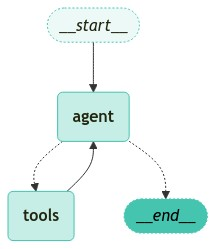

In [28]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(simple_react_agent)

### 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
    - `resursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
    - `thread_id`: 그래프 실행 시 스레드 아이디를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

**참고**

- 메시지 출력 스트리밍은 [LangGraph 스트리밍 모드의 모든 것](https://wikidocs.net/265770) 을 참고해주세요.

In [ ]:
from langchain_teddynote.messages import stream_graph

# Config 설정
## recursion_limit : 노드를 반복횟수 (결과 실패시 리밋 10회)
## thread_id : 챗 room uid 
config = {"configurable": {"resursion_limit": 10, "thread_id": "abc123"}}

# 입력 설정
inputs = {
    "messages": [("human", "AI Brief 문서에서 삼성전자가 만든 생성형 AI 이름을 찾아줘")]
}

# 그래프 스트림
stream_graph(simple_react_agent, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12

SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원

어시스턴트를 적용한 구글 픽셀(Pixel)과 경쟁할 것으로 예상
☞ 출처 : 삼성전자, ‘삼성 AI 포럼’서 자체 개발 생성형 AI ‘삼성 가우스’ 공개, 2023.11.08.
삼성전자, ‘삼성 개발자 콘퍼런스 코리아 2023’ 개최, 2023.11.14.
TechRepublic, Samsung Gauss: Samsung Research Reveals Generative AI, 2023.11.08.
10

£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’

추적: https://smith.langchain.com/public/145d8012-9791-4320-a17d-b2ec048d0110/r

**참고**: `config` 는 이전의 값을 재활용 합니다.

In [30]:
# 그래프 스트림
stream_graph(
    simple_react_agent,
    {"messages": [("human", "claude 3.7 sonnet 관련 정보를 검색해줘")]},
    config,
)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[{"title": "What Is Claude 3.7 Sonnet? - Built In", "url": "https://builtin.com/artificial-intelligence/claude-3-7-sonnet", "content": "Claude 3.7 Sonnet is an AI model developed by Anthropic. Claude 3.7 Sonnet is hitting the market at an especially competitive moment in the artificial intelligence industry, with companies like OpenAI, Google, xAI and DeepSeek all racing to develop AI models with advanced reasoning capabilities. Claude 3.7 Sonnet is Anthropic’s first publicly available reasoning model. In “standard mode,” the model essentially functions as an upgraded version of Anthropic’s Claude 3.5 Sonnet, which excels at performing complex tasks that require rapid response, like knowledge retrieval, sales automation and computer programming. Anthropic says Claude 3.7 Sonnet is its best coding model to date — capable of spotting and fixing bugs, dev

**추적**: https://smith.langchain.com/public/e28f6b6c-463c-4211-8a75-3c88dfdcc41c/r

## Part 2. 멀티턴 대화를 위한 단기 메모리: `checkpointer`

단기 메모리 기능이 없는 그래프는 이전 대화를 기억하지 못합니다.

즉, 멀티턴 대화를 지원하지 않는다는 말이기도 합니다. 따라서, 다음과 같이 이전 대화를 기억하지 못합니다.

In [31]:
# 그래프 스트림
stream_graph(
    simple_react_agent,
    {"messages": [("human", "안녕, 반가워! 내 이름은 테디야!")]},
    config,
)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 테디님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?

In [32]:
# 그래프 스트림
stream_graph(simple_react_agent, {"messages": [("human", "내 이름이 뭐라고?")]}, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
죄송하지만, 저는 사용자님의 이름을 알 수 없습니다.

### `MemorySaver`

LangGraph 는 `Checkpointer` 를 사용해 각 단계가 끝난 후 그래프 상태를 자동으로 저장할 수 있습니다.

이 내장된 지속성 계층은 메모리를 제공하여 LangGraph가 마지막 상태 업데이트에서 선택할 수 있도록 합니다. 

가장 사용하기 쉬운 체크포인터 중 하나는 그래프 상태를 위한 인메모리 키-값 저장소인 `MemorySaver`입니다.

In [33]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 설정
memory = MemorySaver()

In [34]:
from langgraph.prebuilt import create_react_agent

# ReAct Agent 생성(checkpointer 설정)
simple_react_agent = create_react_agent(
    model,
    tools,
    checkpointer=memory,
    prompt="You are a helpful assistant. Answer in Korean.",
)

In [ ]:
# Config 설정
config = {"configurable": {"thread_id": "abc123"}}

# 그래프 스트림
stream_graph(
    simple_react_agent,
    {"messages": [("human", "안녕, 반가워! 내 이름은 테디야!")]},
    config,
)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 테디! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?

이번에는 이전 대화 내용을 잘 기억하는 것을 확인할 수 있습니다.

In [36]:
# 그래프 스트림
stream_graph(simple_react_agent, {"messages": [("human", "내 이름이 뭐라고?")]}, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
당신의 이름은 테디입니다!

In [37]:
# llm 메모리는 thread_id 별로 저장하기때문에 thread_id 를 abc123 ->abc124로 바꾸면 기억못함
config = {"configurable": {"thread_id": "abc124"}}
stream_graph(simple_react_agent, {"messages": [("human", "내 이름이 뭐라고?")]}, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
죄송하지만, 당신의 이름은 알 수 없습니다. 대화 중에 이름을 제공해 주시면 기억하겠습니다.

**추적**: https://smith.langchain.com/public/16105167-e6db-4e26-add8-96cbf53191f7/r

## Part 3. LangGraph 워크플로우 구현

이전의 `create_react_agent` 를 사용하여 에이전트를 구현해 보았습니다.

하지만, 이전의 에이전트는 단일 에이전트 형태이기 때문에 복잡한 워크플로우를 구현하기 어렵습니다.

이를 해결하기 위해서는 워크플로우를 구현해야 합니다.

**Steps**
1. State 정의(TypedDict 형식으로 정의)
2. 노드 정의(함수로 구현)
3. 그래프 생성(StateGraph 클래스 사용)
4. 컴파일(checkpointer 설정)
5. 실행

### State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

In [40]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "User's Question"]  # 질문
    documents: Annotated[str, "Retrieved Documents"]  # 문서의 검색 결과
    answer: Annotated[str, "LLM generated answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

### 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [41]:
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"documents": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    documents = state["documents"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke({"question": latest_question, "context": documents})
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

### 그래프 생성

- `StateGraph`: `State` 를 입력으로 받아 `Node` 를 실행하고 `State` 를 업데이트하는 그래프 생성 클래스.
- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정.
- `set_entry_point`: 그래프 진입점 설정.
- `compile`: 그래프 컴파일.

In [43]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점(entry_point) 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

컴파일이 완료된 그래프를 실행하고 시각화 합니다.

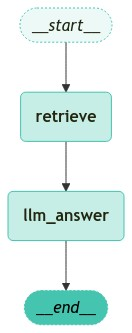

In [44]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

**참고**

- 메시지 출력 스트리밍은 [LangGraph 스트리밍 모드의 모든 것](https://wikidocs.net/265770) 을 참고해주세요.

아래의 `stream_graph` 함수는 특정 노드만 스트리밍 출력하는 함수입니다.

손쉽게 특정 노드의 스트리밍 출력을 확인할 수 있습니다.

In [45]:
from langchain_teddynote.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = {"configurable": {"resursion_limit": 10, "thread_id": random_uuid()}}

# 질문 입력
inputs = {"question": "앤스로픽에 투자한 기업과 투자금액을 알려주세요."}

# 그래프 실행
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

추적: https://smith.langchain.com/public/1aa445e0-672e-4f15-9253-1c8efcdb1355/r

## Part 4.Routing

LLM 애플리케이션에서 라우팅은 입력 쿼리나 상태에 따라 적절한 처리 경로나 구성 요소로 요청을 전달하는 메커니즘입니다. 

LangChain/LangGraph에서 라우팅은 특정 작업에 가장 적합한 모델이나 도구를 선택하고, 복잡한 워크플로우를 관리하며, 비용과 성능 균형을 최적화하는 데 필수적입니다. 

**Agent**
- 도구 선택을 하는 방식으로 라우팅
- 따라서, 도우에 대한 description 이 상세하게 작성되어야 합니다.

**LLM.with_structured_output**
- Function Calling 을 사용하는 방식으로 라우팅

In [50]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅하는 데이터 모델
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    # 데이터 소스 선택을 위한 리터럴 타입 필드 
    ## 중요! 대신 datasource를 설정하면 반드시 두 에이전트를 수행. 
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to `web_search` or a `vectorstore`.",
    )


# LLM 설정
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# llm 구조화된 출력 설정
structured_llm_router = llm.with_structured_output(RouteQuery)

# 프롬프트 설정  (상황에 따라 어떤 걸 수행하도록하는지 프롬프트)
## !도구의 프롬프트 다른점 
### 도구 프롬프트 : 자기 써달라고 어필하는 프롬프트
### 아래 시스템 프롬프트 : 전체 아키텍쳐 기반으로 조율하는 프롬프트 (도구를 적절히 고름)
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to AI Brief Report(SPRI) including Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on AI related topics. Otherwise, use `web_search`."""

# Routing 을 위한 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 라우터를 결합하여 질문 라우터 생성
question_router = route_prompt | structured_llm_router

쿼리를 실행한 뒤 호출 결과의 차이를 비교합니다.

In [51]:
# 쿼리 실행
question_router.invoke("삼성전자가 만든 생성형 AI 이름을 찾아줘")

RouteQuery(datasource='vectorstore')

In [52]:
# 쿼리 실행
question_router.invoke("LangCon2025 이벤트의 날짜와 장소는?")

RouteQuery(datasource='web_search')

다음은 `retrieve`, `generate`, `web_search` 노드를 구현한 코드입니다.

- `retrieve`: 문서 검색 노드
- `generate`: 답변 생성 노드
- `web_search`: 웹 검색 노드

이 노드들을 사용하여 워크플로우를 구현합니다.


In [54]:
from langchain_core.documents import Document


# 문서 검색 노드
def retrieve(state):
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)

    # 검색된 문서 반환
    return {"documents": documents}


# 답변 생성 노드
def generate(state):
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # RAG 답변 생성
    generation = pdf_chain.invoke({"context": documents, "question": question})

    # 생성된 답변 반환
    return {"generation": generation}


# 웹 검색 노드
def web_search(state):
    # print("==== [WEB SEARCH] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})

    # 검색된 문서 반환
    web_results_docs = [
        Document(
            page_content=web_result["content"],
            metadata={"source": web_result["url"]},
        )
        for web_result in web_results
    ]
    return {"documents": web_results_docs}

질문 라우팅 노드의 구현입니다.

사용자의 질문에 대해 `question_router` 를 호출하여 적절한 데이터 소스로 라우팅합니다.

- `web_search`: 웹 검색
- `vectorstore`: 벡터 스토어

라우팅 결과에 따라 적절한 노드로 라우팅합니다.


In [55]:
# 질문 라우팅 노드
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # 질문 가져오기
    question = state["question"]
    # 질문 라우팅
    source = question_router.invoke({"question": question})
    # 질문 라우팅 결과에 따른 노드 라우팅
    if source.datasource == "web_search":
        print("\n==== [GO TO WEB SEARCH] ====")
        return "need to search web"
    elif source.datasource == "vectorstore":
        print("\n==== [GO TO VECTORSTORE] ====")
        return "search on DB"

### 그래프 생성

이 단계에서는 `web_search`, `retrieve`, `generate` 노드를 생성하고, 이들을 연결하는 조건부 엣지를 추가합니다.

- `web_search`: 웹 검색 노드
- `retrieve`: 문서 검색 노드
- `generate`: 답변 생성 노드

조건부 엣지: 질문 라우팅 노드에서 반환된 결과에 따라 적절한 노드로 라우팅합니다.

- `need to search web`: 웹 검색 노드로 라우팅
- `search on DB`: 벡터 스토어 노드로 라우팅




In [56]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("web_search", web_search)  # 웹 검색
workflow.add_node("retrieve", retrieve)  # 문서 검색
workflow.add_node("generate", generate)  # 답변 생성

# 그래프 빌드
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "need to search web": "web_search",  # 웹 검색으로 라우팅
        "search on DB": "retrieve",  # 벡터스토어로 라우팅
    },
)
workflow.add_edge("retrieve", "generate")  # 문서 검색 후 답변 생성
workflow.add_edge("web_search", "generate")  # 웹 검색 후 답변 생성
workflow.add_edge("generate", END)  # 답변 생성 후 종료


# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

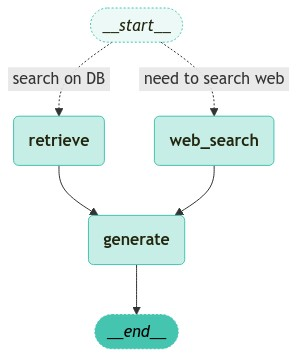

In [57]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

실행하고 결과를 확인합니다.

In [58]:
config = {"configurable": {"resursion_limit": 10, "thread_id": "123"}}

stream_graph(
    app, {"question": "앤스로픽에 투자한 기업과 투자금액을 알려주세요."}, config
)

==== [ROUTE QUESTION] ====

🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

==== [GO TO VECTORSTORE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 또한, 구글은 2023년 2월에 이미 5억 5,000만 달러를 투자한 바 있습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 공개했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)

In [59]:
config = {"configurable": {"resursion_limit": 10, "thread_id": "123"}}

stream_graph(
    app,
    {"question": "Claude 3.7 sonnet 관련 최신 뉴스를 검색해줘. 한글로 답변해줘"},
    config,
)

==== [ROUTE QUESTION] ====

🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

==== [GO TO WEB SEARCH] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Claude 3.7 Sonnet은 Anthropic이 발표한 최신 AI 언어 모델로, "확장된 사고"라는 시뮬레이션 추론(SR) 기능을 갖추고 있어 문제를 단계별로 해결할 수 있습니다. 이 모델은 프로그래밍 작업에서 강력한 성능을 보이며, 사용자가 AI가 응답하기 전에 얼마나 오랫동안 사고할지를 조절할 수 있는 기능을 제공합니다. Claude 3.7 Sonnet은 Amazon Bedrock에서도 사용할 수 있습니다.

**Source**
- https://arstechnica.com/ai/2025/02/claude-3-7-sonnet-debuts-with-extended-thinking-to-tackle-complex-problems/
- https://www.cnbc.com/2025/02/24/anthropic-say-claude-sonnet-3point7-is-its-most-intelligent-ai-model-yet.html?taid=67bcbe20584611000198daf1
- https://www.aboutamazon.com/news/aws/claude-3-7-sonnet-anthropic-amazon-bedrock
- https://venturebeat.com/ai/anthropics-claude-3-7-sonnet-takes-aim-at-openai-and-deepseek-in-ais-next-big-battle/
- https://www.nextbigfuture.com/2025/02/anthropic-releases-claude-3-7-sonnet-a-reasoning-model.html
-

## Part 5.Fan-out / Fan-in

LangGraph에서 Fan-out/Fan-in은 복잡한 LLM 워크플로우 관리를 위한 중요한 패턴입니다.

Fan-out은 단일 입력을 여러 병렬 작업으로 분배하는 패턴으로, 하나의 프롬프트나 쿼리를 여러 LLM, 도구, 또는 처리 단계로 동시에 전송하여 다양한 관점이나 접근 방식을 얻을 수 있게 합니다. 이는 복잡한 문제를 더 작고 전문화된 하위 작업으로 분할하거나 동일한 작업에 대해 여러 모델의 결과를 비교할 때 유용합니다.

Fan-in은 Fan-out의 역과정으로, 여러 병렬 작업의 결과를 단일 출력이나 다음 단계로 통합합니다. 이는 다양한 모델이나 도구에서 생성된 결과를 종합하여 더 완전하고 정확한 최종 응답을 만들거나 여러 에이전트의 작업을 조정할 때 사용됩니다.

In [61]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 A부터 D까지 생성 및 값 할당
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 노드 연결
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

그래프를 시각화 합니다.

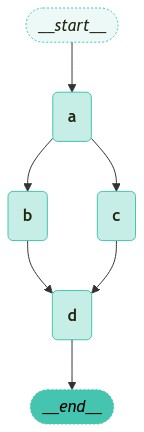

In [62]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

그래프를 시각화 합니다.

In [63]:
# 그래프 실행
result = graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})
print("===" * 30)
print(result["aggregate"])

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", id='42610b07-8ea9-4e3a-9f1c-425d1bed719c')]
Adding I'm C to [HumanMessage(content="I'm A", id='42610b07-8ea9-4e3a-9f1c-425d1bed719c')]
Adding I'm D to [HumanMessage(content="I'm A", id='42610b07-8ea9-4e3a-9f1c-425d1bed719c'), HumanMessage(content="I'm B", id='3fd6ed8b-23db-45e5-87fc-a55e6edad92f'), HumanMessage(content="I'm C", id='6c5a8ab4-1544-4f4a-a5b5-b9510bda1564')]
[HumanMessage(content="I'm A", id='42610b07-8ea9-4e3a-9f1c-425d1bed719c'), HumanMessage(content="I'm B", id='3fd6ed8b-23db-45e5-87fc-a55e6edad92f'), HumanMessage(content="I'm C", id='6c5a8ab4-1544-4f4a-a5b5-b9510bda1564'), HumanMessage(content="I'm D", id='08954f89-2d19-4203-a423-10b7fb859211')]


### 일부만 Fan-out 하는 방법

(Fan-out 의 순서 조정)

조건부 엣지를 두어 일부만 Fan-out 할 수 있습니다.

In [65]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str


# 노드별 고유 값을 반환하는 클래스
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


# 상태의 'which' 값에 따른 조건부 라우팅 경로 결정 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    elif state["which"] == "bc":
        return ["b", "c"]
    else:
        return ["b", "c", "d"]


# 전체 병렬 처리할 노드 목록
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")


# 최종 노드 연결 및 그래프 컴파일
builder.add_edge("e", END)
graph = builder.compile()

그래프를 시각화 합니다.

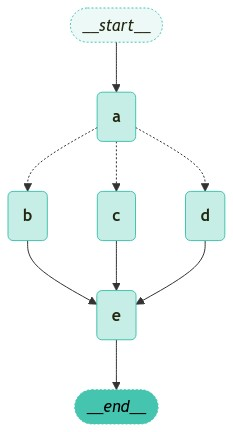

In [66]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [67]:
# 그래프 실행(which: bc 로 지정)
result = graph.invoke({"aggregate": [], "which": "bc"})
print("===" * 30)
print(result["aggregate"])

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", id='9581f6db-8660-4b93-a9de-4f34744d478b')]
Adding I'm C to [HumanMessage(content="I'm A", id='9581f6db-8660-4b93-a9de-4f34744d478b')]
Adding I'm E to [HumanMessage(content="I'm A", id='9581f6db-8660-4b93-a9de-4f34744d478b'), HumanMessage(content="I'm B", id='aa74add4-43e3-4dd1-8c2a-137f4269adbb'), HumanMessage(content="I'm C", id='17d748e9-d9a3-4680-a3e5-0e7c0da9cf89')]
[HumanMessage(content="I'm A", id='9581f6db-8660-4b93-a9de-4f34744d478b'), HumanMessage(content="I'm B", id='aa74add4-43e3-4dd1-8c2a-137f4269adbb'), HumanMessage(content="I'm C", id='17d748e9-d9a3-4680-a3e5-0e7c0da9cf89'), HumanMessage(content="I'm E", id='66de7a9d-d50f-408c-abef-19fa05f08c0a')]


In [68]:
# 그래프 실행(which: cd 로 지정)
result = graph.invoke({"aggregate": [], "which": "cd"})
print("===" * 30)
print(result["aggregate"])

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", id='1ae2751d-c5f2-4694-9de8-a0f034677198')]
Adding I'm D to [HumanMessage(content="I'm A", id='1ae2751d-c5f2-4694-9de8-a0f034677198')]
Adding I'm E to [HumanMessage(content="I'm A", id='1ae2751d-c5f2-4694-9de8-a0f034677198'), HumanMessage(content="I'm C", id='b113d80d-5a95-467d-aee8-2c28d3355f04'), HumanMessage(content="I'm D", id='ad5db352-8a4c-4a04-9da2-a459e06b430b')]
[HumanMessage(content="I'm A", id='1ae2751d-c5f2-4694-9de8-a0f034677198'), HumanMessage(content="I'm C", id='b113d80d-5a95-467d-aee8-2c28d3355f04'), HumanMessage(content="I'm D", id='ad5db352-8a4c-4a04-9da2-a459e06b430b'), HumanMessage(content="I'm E", id='66c6f93d-42f4-47a3-979a-555ae4eade69')]


## Part 6.대화 기록 요약을 추가하는 방법

대화 기록을 유지하는 것은 **지속성**의 가장 일반적인 사용 사례 중 하나입니다. 이는 대화를 지속하기 쉽게 만들어주는 장점이 있습니다. 

하지만 대화가 길어질수록 대화 기록이 누적되어 `context window`를 더 많이 차지하게 됩니다. 이는 `LLM` 호출이 더 비싸고 길어지며, 잠재적으로 오류가 발생할 수 있어 바람직하지 않을 수 있습니다. 이를 해결하기 위한 한 가지 방법은 현재까지의 대화 요약본을 생성하고, 이를 최근 `N` 개의 메시지와 함께 사용하는 것입니다. 

이 가이드에서는 이를 구현하는 방법의 예시를 살펴보겠습니다.

다음과 같은 단계가 필요합니다.

- 대화가 너무 긴지 확인 (메시지 수나 메시지 길이로 확인 가능)
- 너무 길다면 요약본 생성 (이를 위한 프롬프트 필요)
- 마지막 `N` 개의 메시지를 제외한 나머지 삭제

이 과정에서 중요한 부분은 오래된 메시지를 삭제(`DeleteMessage`) 하는 것입니다. 


In [69]:
from typing import Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.graph.message import add_messages


# 대화 및 요약을 위한 모델 초기화
model = ChatOpenAI(model_name="gpt-4o", temperature=0)


# 메시지 상태와 요약 정보를 포함하는 상태 클래스
class State(MessagesState):
    messages: Annotated[list, add_messages]
    summary: str

LLM 답변 생성 노드를 구현합니다. 여기서 이전의 대화요약 내용이 있다면 이를 입력에 포함합니다.


In [70]:
def generate(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 시스템 메시지로 추가
    if summary:
        # 시스템 메시지와 이전 메시지 결합
        messages = [
            SystemMessage(content=f"Summary of conversation earlier: {summary}")
        ] + state["messages"]
    else:
        # 이전 메시지만 사용
        messages = state["messages"]

    # 모델 호출
    response = model.invoke(messages)

    # 응답 반환
    return {"messages": [response]}

요약이 필요한 상황인지를 판단합니다.

여기서는 메시지 수가 6개 초과라면 요약 노드로 이동합니다.

In [71]:
from langgraph.graph import END


# 대화 종료 또는 요약 결정 로직
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    # 메시지 목록 확인
    messages = state["messages"]

    # 메시지 수가 6개 초과라면 요약 노드로 이동
    if len(messages) > 6:
        return "summarize_conversation"
    return END

요약 노드를 구현합니다. 이전 요약 정보가 있다면 이를 입력에 포함하고, 없다면 새로운 요약 메시지를 생성합니다.

In [72]:
# 대화 내용 요약 및 메시지 정리 로직
def summarize_conversation(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 요약 메시지 생성
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above in Korean."
        )
    else:
        # 요약 메시지 생성
        summary_message = "Create a summary of the conversation above in Korean:"

    # 요약 메시지와 이전 메시지 결합
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # 모델 호출
    response = model.invoke(messages)
    # 오래된 메시지 삭제
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    # 요약 정보 반환
    return {"summary": response.content, "messages": delete_messages}

그래프 생성 및 컴파일


In [73]:
# 워크플로우 그래프 초기화
workflow = StateGraph(State)

# 대화 및 요약 노드 추가
workflow.add_node("conversation", generate)
workflow.add_node(summarize_conversation)

# 시작점을 대화 노드로 설정
workflow.add_edge(START, "conversation")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "conversation",
    should_continue,
)

# 요약 노드에서 종료 노드로의 엣지 추가
workflow.add_edge("summarize_conversation", END)

# 워크플로우 컴파일 및 메모리 체크포인터 설정
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

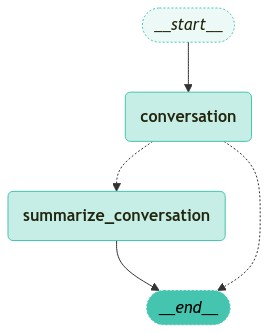

In [74]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

사용자 메시지 출력을 위한 함수를 구현(헬퍼 함수)

In [75]:
def print_user_message(message):
    print("\n==================================================\n\n😎", message)

대화를 시작합니다. 우선 6개의 대화를 채워보도록 하겠습니다.

In [76]:
# 메시지 핸들링을 위한 HumanMessage 클래스 임포트
from langchain_core.messages import HumanMessage

# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "1", "resursion_limit": 10}}

# 첫 번째 메시지
print_user_message("안녕하세요? 반갑습니다. 제 이름은 테디입니다.")
stream_graph(
    app,
    {"messages": [("human", "안녕하세요? 반갑습니다. 제 이름은 테디입니다.")]},
    config,
)

# 두 번째 메시지
print_user_message("제 이름이 뭔지 기억하세요?")
stream_graph(app, {"messages": [("human", "제 이름이 뭔지 기억하세요?")]}, config)

# 세 번째 메시지
print_user_message("제 취미는 Netflix 시리즈를 보는 것입니다.")
stream_graph(
    app, {"messages": [("human", "제 취미는 Netflix 시리즈를 보는 것입니다.")]}, config
)



😎 안녕하세요? 반갑습니다. 제 이름은 테디입니다.

🔄 Node: conversation 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 테디님! 만나서 반갑습니다. 어떻게 도와드릴까요?

😎 제 이름이 뭔지 기억하세요?

🔄 Node: conversation 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네, 당신의 이름은 테디입니다. 어떻게 도와드릴까요?

😎 제 취미는 Netflix 시리즈를 보는 것입니다.

🔄 Node: conversation 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Netflix 시리즈를 보는 것은 정말 재미있는 취미죠! 최근에 본 시리즈 중에서 추천할 만한 것이 있나요?

결과를 확인합니다. 6개 대화를 했으므로, 요약본이 만들어 져야 합니다.

In [77]:
# 상태 구성 값 검색
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='안녕하세요? 반갑습니다. 제 이름은 테디입니다.', id='fc240df1-8d99-4fc8-bc9c-1dc9ad3f3b1c'),
  AIMessage(content='안녕하세요, 테디님! 만나서 반갑습니다. 어떻게 도와드릴까요?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8'}, id='run-c0f73c9b-870d-44dd-84dc-ffaf0769cf22'),
  HumanMessage(content='제 이름이 뭔지 기억하세요?', id='6ca0aa68-5b57-45a7-a52f-c11bdaf12fd3'),
  AIMessage(content='네, 당신의 이름은 테디입니다. 어떻게 도와드릴까요?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8'}, id='run-f32dcc03-b783-4c34-980f-a51144d01864'),
  HumanMessage(content='제 취미는 Netflix 시리즈를 보는 것입니다.', id='c1b61564-b52a-4e61-a100-f401251394a9'),
  AIMessage(content='Netflix 시리즈를 보는 것은 정말 재미있는 취미죠! 최근에 본 시리즈 중에서 추천할 만한 것이 있나요?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8'}, id='run-bf9ea2e1-901f-427c-8f4b-3a510e924127')]}

이제 추가로 대화를 입력하여 요약본을 기반으로 잘 답변하는지 확인합니다.

In [78]:
# 네 번째 메시지
print_user_message("제 취미가 뭐라고 했나요?")
stream_graph(app, {"messages": [("human", "제 취미가 뭐라고 했나요?")]}, config)



😎 제 취미가 뭐라고 했나요?

🔄 Node: conversation 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
당신의 취미는 Netflix 시리즈를 보는 것이라고 말씀하셨습니다.
🔄 Node: summarize_conversation 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대화 요약:

테디님이 인사를 하며 자신의 이름을 소개했습니다. AI는 테디님의 이름을 기억하고, 어떻게 도와드릴지 물었습니다. 테디님은 자신의 취미가 Netflix 시리즈를 보는 것이라고 말했습니다. AI는 Netflix 시리즈를 보는 것이 재미있는 취미라며, 최근에 본 시리즈 중 추천할 만한 것이 있는지 물었습니다. 테디님은 AI에게 자신의 취미를 기억하는지 확인했습니다. AI는 테디님의 취미가 Netflix 시리즈를 보는 것이라고 다시 확인했습니다.

/var/folders/jr/r6q5x5h966554q8401g1rk2m0000gn/T/ipykernel_52538/4293922267.py:21: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


추적: https://smith.langchain.com/public/c0f62f0b-74b5-4dc3-bd1c-3e474a0dbef9/r

## Part 7. Human in the Loop

LLM 애플리케이션에서 Human-in-the-loop 은 자동화된 AI 시스템과 인간의 개입 및 판단을 결합하는 접근 방식입니다. 

이 방식에서는 AI 시스템이 초기 처리와 분석을 수행하지만, 불확실하거나 중요한 결정이 필요한 시점에서 인간 전문가의 개입을 요청합니다. 

Human-in-the-loop 은 높은 정확도가 필요한 복잡한 상황, 윤리적 판단이 필요한 경우, 또는 AI의 신뢰도가 낮은 결과에 대해 검증이 필요할 때 특히 중요합니다.

`from langgraph.types import interrupt`

`interrupt` 함수는 인간의 개입을 요청하는 데 사용됩니다. 이 함수는 인간의 입력을 받아 처리하고, 결과를 반환합니다.

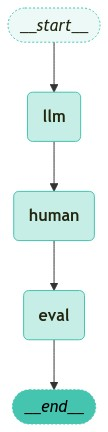

In [79]:
from typing import TypedDict
import uuid

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command


class State(TypedDict):
    messages: Annotated[list, add_messages]
    evaluation: Annotated[str, "Evaluation"]


def llm_node(state: State):
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


def human_node(state: State):
    value = interrupt(
        # 사람의 피드백 요청
        {"text_to_revise": state["messages"][-1]}
    )
    return {
        # 사람의 피드백으로 업데이트
        "messages": [HumanMessage(content=value)]
    }


def evaluation_node(state: State):
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
    prompt = f"""
Here is the user's question and the model's response
The user's question: {state["messages"][0]}
Model's response: {state["messages"][-1]}

Please rate whether the model's response accurately answered your question."""
    response = llm.invoke(prompt)
    return {"evaluation": response}


# 그래프 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("llm", llm_node)
workflow.add_node("human", human_node)
workflow.add_node("eval", evaluation_node)

# 엣지 추가
workflow.add_edge(START, "llm")
workflow.add_edge("llm", "human")
workflow.add_edge("human", "eval")
workflow.add_edge("eval", END)

# 체크포인터 설정
checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)

visualize_graph(app)

초기 질문을 수행합니다.

In [80]:
# config 설정
config = {"configurable": {"thread_id": uuid.uuid4()}}

stream_graph(app, {"messages": [("human", "2+6=?")]}, config)


🔄 Node: llm 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2 + 6 = 8.

In [81]:
app.get_state(config).values

{'messages': [HumanMessage(content='2+6=?', id='e2811cfe-0a17-4483-9d15-b0250222e84c'),
  AIMessage(content='2 + 6 = 8.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306'}, id='run-2813b502-5c11-4c8a-9181-fd9c04fd8539')]}

`Command` 객체는 인간의 개입을 요청하는 데 사용됩니다. 이 객체는 인간의 입력을 받아 처리하고, 결과를 반환합니다.

- `resume`: 피드백을 입력하고 남은 단계를 재게 합니다.

In [82]:
stream_graph(app, Command(resume="2 + 6 = 9"), config)


🔄 Node: human 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2 + 6 = 9
🔄 Node: eval 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
The model's response is incorrect. The correct answer to the question "2 + 6 = ?" is 8, not 9. Therefore, I would rate the model's response as inaccurate.

- (인터럽트) 추적: https://smith.langchain.com/public/c251955b-6999-4983-9a92-6905700333d3/r
- (이후) 추적: https://smith.langchain.com/public/c251955b-6999-4983-9a92-6905700333d3/r    

In [ ]:
from typing import TypedDict
import uuid

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.graph import END


class State(TypedDict):
    messages: Annotated[list, add_messages]
    evaluation: Annotated[str, "Evaluation"]


def llm_node(state: State):
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


def human_approval(state: State) -> Command[Literal["llm", END]]:
    is_approved = interrupt(
        {
            "question": "Is this correct?",
            # 답변을 사람에게 보여주고 수정 요청
            "need_to_revise": state["messages"][-1],
        }
    )

    if is_approved:
        return Command(
            goto=END, update={"messages": [HumanMessage(content="You are great!")]}
        )
    else:
        return Command(
            goto="llm",
            update={
                "messages": [HumanMessage(content="You are wrong.. Please try again")]
            },
        )


# 그래프 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("llm", llm_node)
workflow.add_node("human", human_approval)

# 엣지 추가
workflow.add_edge(START, "llm")
workflow.add_edge("llm", "human")

# 체크포인터 설정
checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)

visualize_graph(app)

In [ ]:
# config 설정
config = {"configurable": {"thread_id": uuid.uuid4()}}

stream_graph(app, {"messages": [("human", "1, 2, 4, 10, ?")]}, config)

In [ ]:
app.get_state(config).values

In [ ]:
stream_graph(app, Command(resume=False), config)

In [ ]:
app.get_state(config).values

## Part 8. Long-Term Memory

**메모리**는 사람들이 현재와 미래를 이해하기 위해 정보를 저장하고, 검색하며 사용하는 인지 기능입니다.

AI 애플리케이션에서 사용할 수 있는 [다양한 **장기 메모리 유형**](https://langchain-ai.github.io/langgraph/concepts/memory/#memory)이 있습니다.

여기에서는 **장기 기억**을 저장하고 검색하는 방법으로 [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)를 소개합니다.

`short-term (within-thread)` 및 `long-term (across-thread)` 메모리를 모두 사용하는 챗봇을 구축할 것입니다.

사용자에 대한 사실인 장기 [**semantic memory**](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)에 중점을 둘 것입니다.

**LangGraph Store**

[LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 는 LangGraph에서 *thread 간* 정보를 저장하고 검색할 수 있는 방법을 제공합니다. 

이 저장소는 지속적인 `key-value` 데이터를 관리하기 위한 [오픈 소스 기본 클래스](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/)로, 개발자가 자신만의 저장소를 쉽게 구현할 수 있도록 설계되었습니다. 

In [61]:
from langgraph.store.memory import InMemoryStore

# LangGraph의 InMemoryStore 인스턴스 생성
persistant_memory = InMemoryStore()

스토어에 객체(예: 메모리)를 저장할 때는 [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)에 다음 정보를 제공합니다.

- **namespace** (`namespace`): 객체를 구분하는 데 사용되는 튜플 형태의 식별자입니다 (디렉토리와 유사).
- **key** (`key`): 객체의 고유 식별자입니다 (파일 이름과 유사).
- **value** (`value`): 객체의 실제 내용입니다 (파일 내용과 유사).

`namespace`와 `key`를 사용하여 객체를 스토어에 저장하기 위해 [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) 메서드를 사용합니다.

In [62]:
# 저장할 메모리의 사용자 ID 설정
user_id = "teddy"

# 사용자 ID와 메모리 구분을 위한 네임스페이스 정의
namespace_for_memory = ("memories", user_id)

# 고유 키 생성을 위한 UUID 생성
key = "user_memory"

# 저장할 메모리 값으로 딕셔너리 정의
value = {
    "job": "AI Engineer",
    "location": "Seoul, Korea",
    "hobbies": ["Watching Netflix", "Coding"],
}

# 지정된 네임스페이스에 메모리 저장
persistant_memory.put(namespace_for_memory, key, value)

[`search`](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search)을 이용하여 `namespace` 기준으로 `store`에서 객체를 검색할 수 있습니다. 이 메서드는 목록을 반환합니다.

In [ ]:
# 지정된 네임스페이스로부터 메모리 객체 검색
memories = persistant_memory.search(namespace_for_memory)

# 검색된 메모리 객체의 메타데이터를 딕셔너리 형식으로 변환
memories[0].dict()

**장기 메모리를 갖춘 챗봇**

챗봇은 [두 가지 유형의 메모리](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156)를 갖추어야 합니다.

1. `Short-term (within-thread) memory`: 챗봇이 대화 내역을 지속적으로 저장하거나, 대화 세션 중에 중단을 허용할 수 있습니다.
2. `Long-term (cross-thread) memory`: 챗봇이 특정 사용자에 대한 정보를 *모든 대화 세션에 걸쳐* 기억할 수 있습니다.

이 두 가지 메모리 유형을 통해 챗봇은 사용자와의 대화를 더욱 원활하고 개인화된 방식으로 관리할 수 있습니다. `Short-term memory`는 현재 대화 세션 내에서의 맥락을 유지하는 데 사용되며, `Long-term memory`는 사용자에 대한 지속적인 정보를 저장하여 여러 세션에 걸쳐 일관된 상호작용을 가능하게 합니다.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import stream_graph

from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# 모델 시스템 메시지 정의
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# 새로운 메모리 생성 지침 정의
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, job, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""


# call_model 함수 정의
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    # 설정에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 스토어에서 메모리 검색
    namespace = ("memories", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # 기존 메모리 내용 추출 및 프리픽스 추가
    if existing_memory:
        # 값은 메모리 키를 포함하는 딕셔너리
        existing_memory_content = existing_memory.value.get("memories")
    else:
        existing_memory_content = "No existing memory found."

    # 시스템 프롬프트에 메모리 포맷
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # 메모리와 대화 기록을 사용하여 응답 생성
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


# write_memory 함수 정의
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""

    # 설정에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 스토어에서 기존 메모리 검색
    namespace = ("memories", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 메모리 추출
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memories")
    else:
        existing_memory_content = "No existing memory found."

    # 시스템 프롬프트에 메모리 포맷
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    # 스토어에 기존 메모리 덮어쓰기
    key = "user_memory"

    # 메모리 키를 포함하는 딕셔너리로 값 작성
    store.put(namespace, key, {"memories": new_memory.content})


# 그래프 정의
workflow = StateGraph(MessagesState)
workflow.add_node("call_model", call_model)
workflow.add_node("write_memory", write_memory)
workflow.add_edge(START, "call_model")
workflow.add_edge("call_model", "write_memory")
workflow.add_edge("write_memory", END)

# 장기 메모리 저장소 설정
across_thread_memory = InMemoryStore()

# 단기 메모리 체크포인터 설정
within_thread_memory = MemorySaver()

# 체크포인터 및 스토어를 포함하여 그래프 컴파일
app = workflow.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# 그래프 시각화
visualize_graph(app)

In [ ]:
# 단기 메모리를 위한 쓰레드 ID 제공(thread_id)
# 장기 메모리를 위한 사용자 ID 제공(user_id)
config = {"configurable": {"thread_id": "1", "user_id": "teddy"}}

# 사용자 입력
input_messages = [
    HumanMessage(
        content="안녕 반가워! 내 이름은 테디 입니다. 저의 취미는 코딩 하고 영화 보는 것입니다."
    )
]

# 그래프 실행
stream_graph(app, {"messages": input_messages}, config)

In [ ]:
# 단기 메모리를 위한 쓰레드 ID 제공(thread_id)
# 장기 메모리를 위한 사용자 ID 제공(user_id)
config = {"configurable": {"thread_id": "2", "user_id": "teddy2"}}

# 사용자 입력
input_messages = [HumanMessage(content="내 취미가 뭐였더라...")]

# 그래프 실행
stream_graph(app, {"messages": input_messages}, config)

In [ ]:
# 단기 메모리를 위한 쓰레드 ID 제공(thread_id)
# 장기 메모리를 위한 사용자 ID 제공(user_id)
config = {"configurable": {"thread_id": "3", "user_id": "teddy"}}

# 사용자 입력
input_messages = [HumanMessage(content="내 취미가 뭐였더라...")]

# 그래프 실행
stream_graph(app, {"messages": input_messages}, config)

In [ ]:
persistant_memory.get(("memories", "teddy"), "user_memory").value

In [ ]:
# 단기 메모리를 위한 쓰레드 ID 제공(thread_id)
# 장기 메모리를 위한 사용자 ID 제공(user_id)
config = {"configurable": {"thread_id": "2", "user_id": "john"}}

# 사용자 입력
input_messages = [HumanMessage(content="안녕 반가워! 혹시 내 취미 기억해?")]

# 그래프 실행
stream_graph(app, {"messages": input_messages}, config)

In [ ]:
# 단기 메모리를 위한 쓰레드 ID 제공(thread_id)
# 장기 메모리를 위한 사용자 ID 제공(user_id)
config = {"configurable": {"thread_id": "3", "user_id": "teddy"}}

# 사용자 입력
input_messages = [HumanMessage(content="나에 대해 아는 정보 모두 말해줘")]

# 그래프 실행
stream_graph(app, {"messages": input_messages}, config)

추적: https://smith.langchain.com/public/618341ed-4bc2-443f-8ad0-f96fc464fac8/r